In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.append('../')
sys.argv=[''] 
del sys

In [5]:
cd "/root/SymmNeRF-baseline/code"

/root/SymmNeRF-baseline/code


In [19]:
from opt import config_parser
import torch 
import numpy as np 
import matplotlib.pyplot as plt 
import setproctitle
import tqdm 
parser = config_parser()
args = parser.parse_args()

device = torch.device("cuda:1")
args.archCNN = 'resnet34'

det = args.det
lindisp = args.lindisp
args.distributed = False
args.local_feature_ch = 512
args.local_rank = 1
args.eval_scene = 'cars'
args.eval_dataset = 'srns_dataset'
args.num_local_layers = 2
args.enforce_symmetry = {'status':False,
                         'on_coarse':False,'on_fine':False,
                         'concatenate_on_coarse':False, 'concatenate_on_fine':False}
args.module_with_cosine = {'use':False,'G':16}
args.no_load_opt = True
args.no_load_scheduler = True

setproctitle.setproctitle('[Gaetan - SymmNeRF Test]')

In [20]:
# Create training dataset
from torch.utils.data import DataLoader
from datasets.srns_overfit import SRNsDatasetOverfit
import matplotlib.pyplot as plt 

args.N_iters = 1000

train_dataset = SRNsDatasetOverfit(args,mode='train',nb_iter = args.N_iters)

train_loader = DataLoader(train_dataset, batch_size= 1,#args.batch_size,
                              worker_init_fn=lambda _: np.random.seed(),
                              num_workers=args.workers,
                              pin_memory=False,
                              sampler=None,
                              shuffle=True)
print(f'Selected car Id: {train_dataset.specific_observation_id}')
# Create criterion
criterion = torch.nn.MSELoss()

[Info] Loading SRNs dataset for overfitting: /data/srn_cars/cars_train
Selected car Id: adda68ed2da5cee0a413908c0e169330


#### Ensure the data_loader works correctly. 

In [8]:
from model import model_dict
from model.sample_ray import RaySampler
from model.render_ray import render_rays
from evaluation.eval_benchmark import pred_single_image
from skimage.metrics import peak_signal_noise_ratio as PSNR
import tqdm 

In [9]:
from model.model import HyperNeRFResNetSymmLocal

In [21]:
args.local_feature_ch = 1024
args.use_first_layer_as_F = False
args.no_first_pool = False
args.learnable_feature_upsampling = {'use':False,'type':None}
model = HyperNeRFResNetSymmLocal(args,ckpts_folder = '')#/root/SymmNeRF-baseline/logs/srns_dataset/cars/baseline/ckpts/')

[Info] No ckpts found, training from scratch...


In [ ]:
I_target_list = []
I_source_list = []
I_pred_relu = []

with tqdm.tqdm(train_loader,desc = 'Overfitting training') as t:
    for i,data in enumerate(t):
        
        ray_sampler = RaySampler(data)
    
        ray_batch = ray_sampler.random_sample(args.N_rand,device, use_bbox=False)

        z = model.encode(ray_batch['src_img'])

        ret = render_rays(ray_batch = ray_batch,
                          model = model,
                          device = device,
                          latent_vector = z,
                          enforceSymm = args.enforce_symmetry,
                          N_samples = args.N_samples,
                          module_with_cosine = args.module_with_cosine,
                          lindisp = args.lindisp,
                          N_importance = args.N_importance,
                          det = args.det,
                          raw_noise_std = args.raw_noise_std,
                          white_bkgd = args.white_bkgd)
        
        # Compute loss
        loss = criterion(ret['outputs_coarse']['rgb'], ray_batch['rgb']) + criterion(ret['outputs_fine']['rgb'], ray_batch['rgb'])

        loss.backward()
        t.set_description(f'Training loss: {loss.item():.4f}')
        model.optimizer.step()
        model.scheduler.step()
       
    torch.cuda.empty_cache()

Training loss: 0.1441:  39%|███▉      | 394/1000 [11:28<17:35,  1.74s/it]

In [15]:
model.switch_to_eval()
render_list = list(range(ray_sampler.render_imgs[0].shape[0]))
render_list.remove(ray_sampler.src_view[0])
render_view = np.random.choice(render_list, 1)[0]

gt_img = ray_sampler.render_imgs[0][render_view].permute(1, 2, 0)
src_img = ray_sampler.render_imgs[0][ray_sampler.src_view[0]].permute(1,2,0)
            
rgb_pred = pred_single_image(args,model,device,ray_sampler,render_view)
            
It = gt_img.numpy()
Is = src_img.numpy()
Ifine = rgb_pred.numpy()
         
psnr = PSNR(It,Ifine)
print(f'Loss based: {loss}')
print(f'PSNR based: {psnr:.3f}dB ')

Loss based: 0.1442689448595047
PSNR based: 11.068dB 


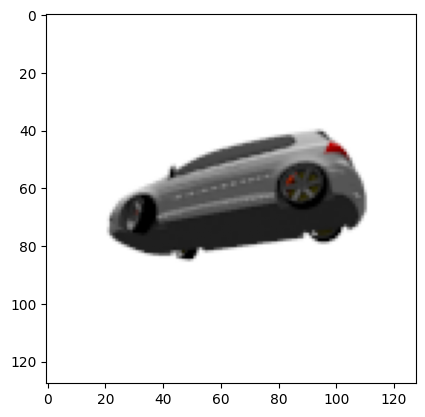

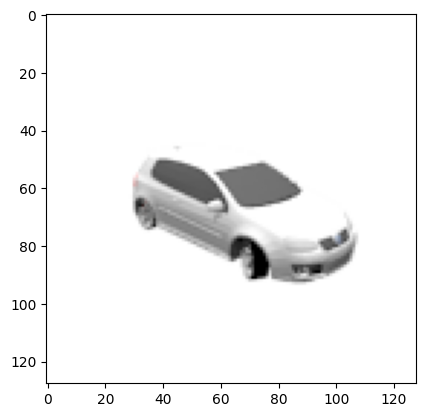

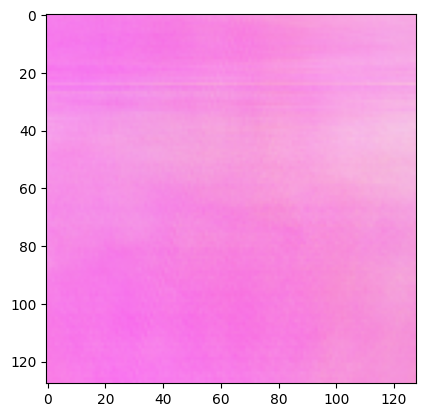

In [18]:
plt.figure()
plt.imshow(Is)
plt.show()
plt.figure()
plt.imshow(It)
plt.show()
plt.figure()
plt.imshow(Ifine)
plt.show()

In [ ]:
I_target_list = []
I_source_list = []
I_pred_relu = []
I_pred_gauss = []

for global_step in tqdm.tqdm(range(5000)):
       
        
    ray_batch = ray_sampler.random_sample(args.N_rand,device, use_bbox=(global_step <= args.no_bbox_step))

    z_relu = model_relu.encode(ray_batch['src_img'])
    z_gaussian = model_gaussian.encode(ray_batch['src_img'])

    
    ret_relu = render_rays(ray_batch = ray_batch,
                          model = model_relu,
                          device = device,
                          latent_vector = z_relu,
                          enforceSymm = args.enforce_symmetry,
                          N_samples = args.N_samples,
                          lindisp = args.lindisp,
                          N_importance = args.N_importance,
                          det = args.det,
                          raw_noise_std = args.raw_noise_std,
                          white_bkgd = args.white_bkgd)
    
    ret_gaussian = render_rays(ray_batch = ray_batch,
                          model = model_gaussian,
                          device = device,
                          latent_vector = z_gaussian,
                          enforceSymm = args.enforce_symmetry,
                          N_samples = args.N_samples,
                          lindisp = args.lindisp,
                          N_importance = args.N_importance,
                          det = args.det,
                          raw_noise_std = args.raw_noise_std,
                          white_bkgd = args.white_bkgd)
    
    
    model_relu.optimizer.zero_grad()
    model_gaussian.optimizer.zero_grad()
    
    # Compute loss
    loss_relu = criterion(ret_relu['outputs_coarse']['rgb'], ray_batch['rgb']) + criterion(ret_relu['outputs_fine']['rgb'], ray_batch['rgb'])
    loss_gaussian = criterion(ret_gaussian['outputs_coarse']['rgb'], ray_batch['rgb']) + criterion(ret_gaussian['outputs_fine']['rgb'], ray_batch['rgb'])


    loss_relu.backward()
    model_relu.optimizer.step()
    
    loss_gaussian.backward()
    model_gaussian.optimizer.step()
    
    
    if global_step % 100 == 0:
            

            render_list = list(range(ray_sampler.render_imgs[0].shape[0]))
            render_list.remove(ray_sampler.src_view[0])
            render_view = np.random.choice(render_list, 1)[0]

            gt_img = ray_sampler.render_imgs[0][render_view].permute(1, 2, 0)
            src_img = ray_sampler.render_imgs[0][ray_sampler.src_view[0]].permute(1,2,0)
            
            
            rgb_pred_relu = pred_single_image(args,model_relu,device,ray_sampler,render_view)
            rgb_pred_gaussian = pred_single_image(args,model_gaussian,device,ray_sampler,render_view)
            
            It = gt_img.numpy()
            Is = src_img.numpy()
            Ifine_relu = rgb_pred_relu.numpy()
            Ifine_gaussian = rgb_pred_gaussian.numpy()
            
            I_target_list.append(It)
            I_source_list.append(Is)
            I_pred_relu.append(Ifine_relu)
            I_pred_relu.append(Ifine_gaussian)
            
            psnr_relu = PSNR(It,Ifine_relu)
            psnr_gaussian = PSNR(It,Ifine_gaussian)
            print(f'Loss-ReLU based: {loss_relu} // Loss-Gaussian based: {loss_gaussian}')
            print(f'PSNR-ReLU based: {psnr_relu:.3f}dB // PSNR-Gaussian based: {psnr_gaussian:.3f}dB')
            

In [38]:
render_list = list(range(ray_sampler.render_imgs[0].shape[0]))
render_list.remove(ray_sampler.src_view[0])
render_view = np.random.choice(render_list, 1)[0]

gt_img = ray_sampler.render_imgs[0][render_view].permute(1, 2, 0)
src_img = ray_sampler.render_imgs[0][ray_sampler.src_view[0]].permute(1,2,0)

rgb_pred_vit = get_intermediate_visuals(args,model_vit,projector,M,device,ray_sampler,render_view)
rgb_pred_baseline = get_intermediate_visuals(args,model_baseline,projector,M,device,ray_sampler,render_view)
            
It = gt_img.numpy()
Is = src_img.numpy()
Ifine_vit = rgb_pred_vit.numpy()
Ifine_baseline = rgb_pred_baseline.numpy()
            
I_target_list.append(It)
I_source_list.append(Is)
I_pred_vit_list.append(Ifine_vit)
I_pred_baseline_list.append(Ifine_baseline)
            
psnr_vit = PSNR(It,Ifine_vit)
psnr_baseline = PSNR(It,Ifine_baseline)
print(f'Loss vit: {loss_vit} - Loss baseline: {loss_baseline}')
print(f'PSNR ViT: {psnr_vit} - PSNR baseline: {psnr_baseline}')

Loss vit: 0.008937052451074123 - Loss baseline: 0.009479139000177383
PSNR ViT: 27.993803279767867 - PSNR baseline: 28.417527054669826


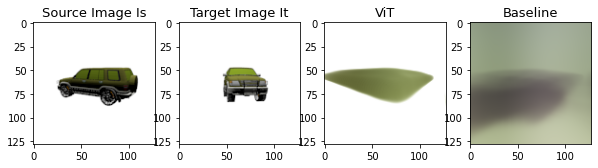

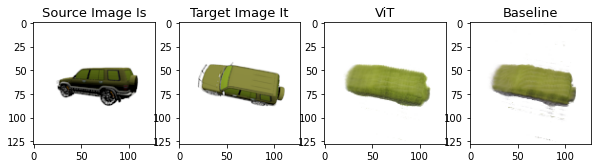

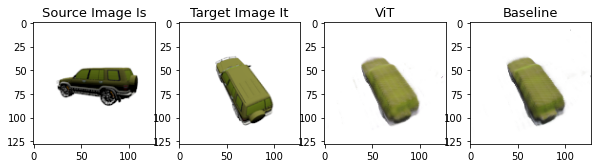

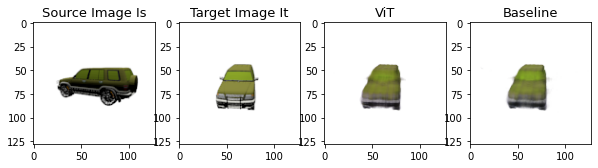

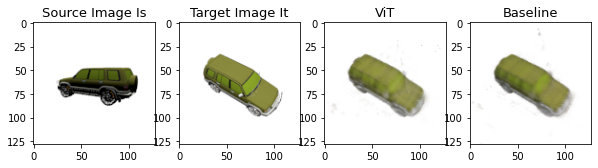

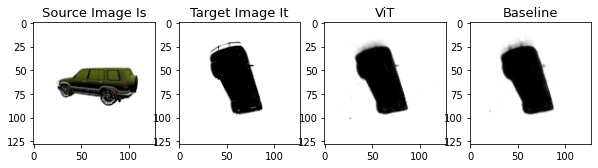

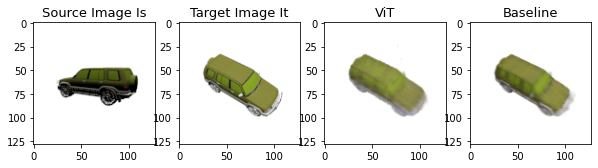

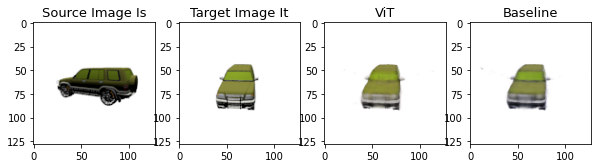

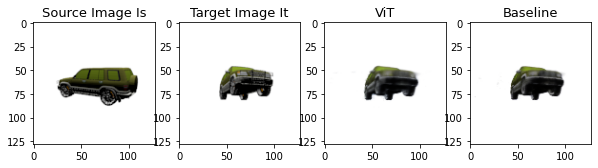

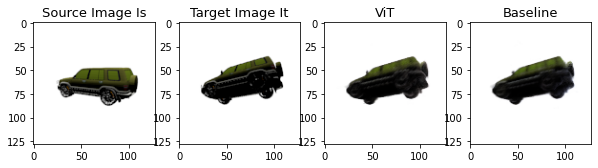

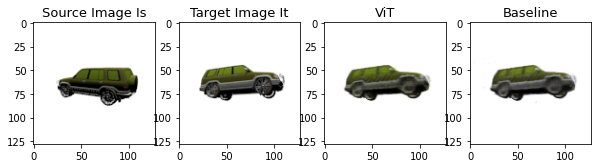

In [39]:
nb_imgs = len(I_target_list)

for i in range(nb_imgs):
    fig, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(10, 10))

    It = I_target_list[i]
    Is = I_source_list[i]
    Ipred_vit = I_pred_vit_list[i]
    Ipred_baseline = I_pred_baseline_list[i]
    
    ax1.imshow(Is)
    ax2.imshow(It)
    ax3.imshow(Ipred_vit)
    ax4.imshow(Ipred_baseline)
            
    ax1.set_title('Source Image Is', fontsize=13)
    ax2.set_title('Target Image It', fontsize=13)
    ax3.set_title('ViT', fontsize=13)
    ax4.set_title('Baseline',fontsize=13)
            
    plt.show()

In [22]:
from model.feature_network import ResNetVision
import torch 
model = ResNetVision(features=256)
x = torch.zeros([1,3,128,128])

y = model(x)

Groups:1 - base_width: 64
Groups:1 - base_width: 64
Groups:1 - base_width: 64


In [23]:
print(y.shape)

torch.Size([1, 128, 64, 64])


In [3]:
import numpy as np 

idx_hundred_random = np.random.randint(0,100,30)
print(idx_hundred_random)
idx = [i+i_rand for i,i_rand in zip(range(0,3000,100),idx_hundred_random)]
print(idx)

[61 25 79 60 47 30 84 30  8  4 11 95 62 27 98 78 63 51 78 92 27 97 35  7
 82 17 15 89 57 65]
[61, 125, 279, 360, 447, 530, 684, 730, 808, 904, 1011, 1195, 1262, 1327, 1498, 1578, 1663, 1751, 1878, 1992, 2027, 2197, 2235, 2307, 2482, 2517, 2615, 2789, 2857, 2965]
